In [81]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os

In [82]:
# 数据集：
# 'source/1.1'
# 'source/1.2' 不推荐使用 没有正常的模板
# 'source/1.3'

source_path = 'source/1.1'
config_file_path = os.path.join(source_path, 'config.yaml')



In [83]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )

(
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
) = load_specific_config(config_file_path)

# 打印提取的配置项以检查是否正确加载
print(f"Image Path: {image_path}")
print(f"Candidate Points: {candidate_point}\n")
print(f"Zone Point: {zone_point}")
print(f"Zone Radius: {zone_radius}")
print(f"Zone Theta: {zone_theta}")
print(f"Valid Threshold: {valid_threshold}")
print(f"step {step}")
print(f"Start Point: {START_POINT}\nEnd Point: {END_POINT}")
print(f"Precision: {PRESICISION}\nUnit: {UNIT}")

Image Path: source/1.1/template2.jpg
Candidate Points: [[700, 766], [624, 659], [603, 528], [647, 403], [745, 311], [851, 276], [981, 292], [1086, 361], [1152, 472], [1160, 601], [1107, 720]]

Zone Point: [970, 362]
Zone Radius: 15
Zone Theta: 10
Valid Threshold: 70
step 5
Start Point: -0.1
End Point: 0.9
Precision: 2
Unit: MPa


In [84]:
img1 = cv2.imread(image_path)
img2 = cv2.imread('source/1.1/img/tv20171228105011CF2FC4.jpg')
candidate_point = np.array(candidate_point)

In [85]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(12, 12))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

In [86]:
from scipy.optimize import least_squares
import numpy as np

def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters

    # Calculate the actual distances from the points to the two foci
    distance_to_focus_1 = np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2)
    distance_to_focus_2 = np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)

    # Return the difference between actual and target distances for each point
    return distance_to_focus_1 + distance_to_focus_2 - sum_of_target_distance

def fit_ellipse(x_samples, y_samples):

    # Compute the centroid of the samples
    centroid_x = np.mean(x_samples)
    centroid_y = np.mean(y_samples)

    # Find the point farthest from the centroid
    distances_from_centroid = np.sqrt((x_samples - centroid_x) ** 2 + (y_samples - centroid_y) ** 2)
    max_distance_index = np.argmax(distances_from_centroid)
    far_point_x = x_samples[max_distance_index]
    far_point_y = y_samples[max_distance_index]

    # Initial guess for the second focus
    x_focus_2_init = far_point_x
    y_focus_2_init = far_point_y

    # Estimate the sum of distances from any point on the ellipse to the foci
    sum_of_target_distance_init = 2 * distances_from_centroid[max_distance_index]

    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([centroid_x, centroid_y, x_focus_2_init, y_focus_2_init, sum_of_target_distance_init])
    res_optimized = least_squares(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))

    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x

        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)

        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)

        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt(a_res**2 - (l_ab / 2)**2)  # Semi-minor axis length

        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:
        print('Fail to fit ellipse')
        return None


# (x, y) rotate around (h,k) with alpha
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot
def get_Point_in_ellipse(a, b, theta):
    return a * np.cos(theta) , b * np.sin(theta)

def Point_in_ellipse(h, k, a, b, alpha, theta):
    x0, y0 = np.cos(theta), np.sin(theta)
    x_real_rot, y_real_rot = rotate(x0, y0, -alpha)
    x_real_rot, y_real_rot = get_Point_in_ellipse(a, b, np.arctan2(y_real_rot, x_real_rot))
    x_res, y_res = rotate(x_real_rot, y_real_rot, alpha)
    return x_res + h, y_res + k

In [87]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

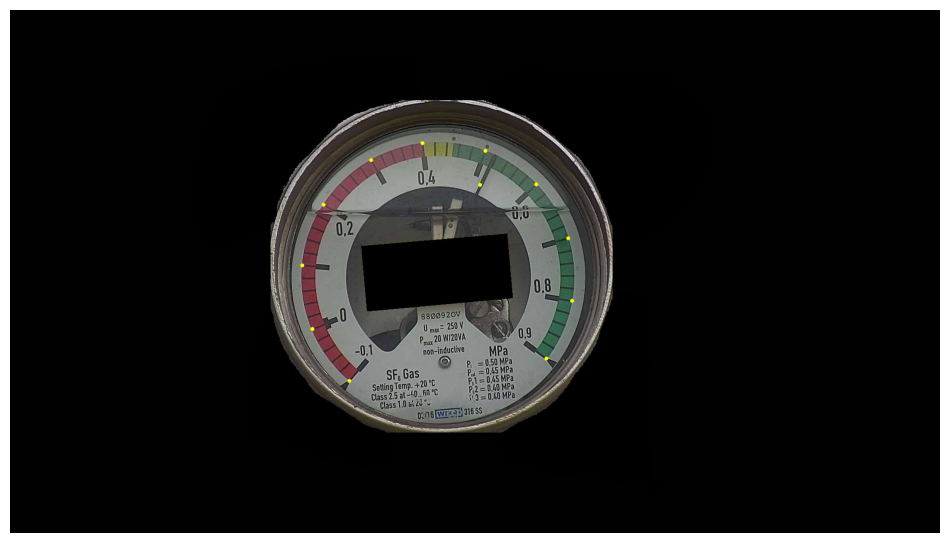

In [88]:
candidate_point = np.vstack((candidate_point, zone_point))

x_samples = candidate_point.T[0]
y_samples = candidate_point.T[1]
show_point(img1, x_samples, y_samples, reversed=False)

In [89]:
# 使用单应矩阵 对点进行转换
# 图像坐标系
def transform_point_with_H(x_point, y_point, H):
    point = np.array([x_point, y_point], dtype=np.float32).T
    projected_points = (cv2.perspectiveTransform(point.reshape(-1,1,2), H).reshape(-1,2).T)
    return projected_points[0], projected_points[1]


def warp_image_and_points_with_H(H, img2, x_point, y_point):
    # 获取img2的尺寸
    height, width = img2.shape[:2]

    # 定义img2四个角点的位置
    corners = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)

    # 使用perspectiveTransform来找到四个角点变换后的位置
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # 找到变换后的最小外接矩形
    x_min = min(transformed_corners[:, 0, 0])
    y_min = min(transformed_corners[:, 0, 1])
    x_max = max(transformed_corners[:, 0, 0])
    y_max = max(transformed_corners[:, 0, 1])

    # 计算新图像的宽度和高度
    new_width = int(np.round(x_max - x_min))
    new_height = int(np.round(y_max - y_min))

    # 调整H矩阵，使得变换后的图像不被裁剪
    translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    adjusted_H = np.dot(translation_matrix, H)

    # 应用透视变换到图像
    warped_img2 = cv2.warpPerspective(img2, adjusted_H, (new_width, new_height))

    # 将输入的点转换为正确的格式，并应用相同的变换矩阵
    points = np.array([x_point, y_point], dtype=np.float32).T.reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(points, translation_matrix).reshape(-1, 2).T
    # 返回变换后的图像和点集
    return warped_img2, transformed_points[0], transformed_points[1]


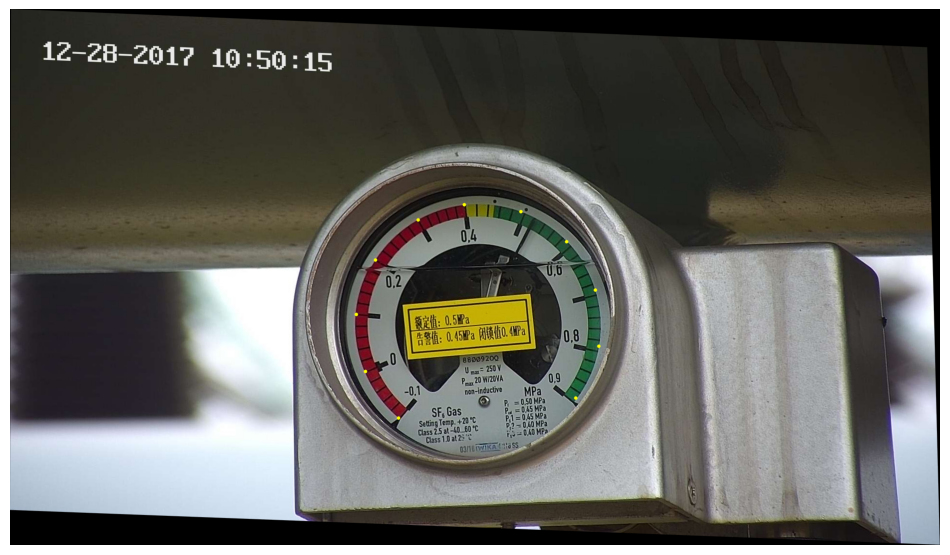

In [90]:
# 对待测图进行矫正 将标注点标注在新的图像上

H_img2_img1 = SIFT4H(img2, img1, False)
work_img, x_img_correct, y_img_correct = warp_image_and_points_with_H(H_img2_img1, img2, x_samples, y_samples)

zone_point_correct = (x_img_correct[-1], y_img_correct[-1])
x_img_correct = x_img_correct[:-1]
y_img_correct = y_img_correct[:-1]

show_point(work_img, x_img_correct, y_img_correct, reversed=False)

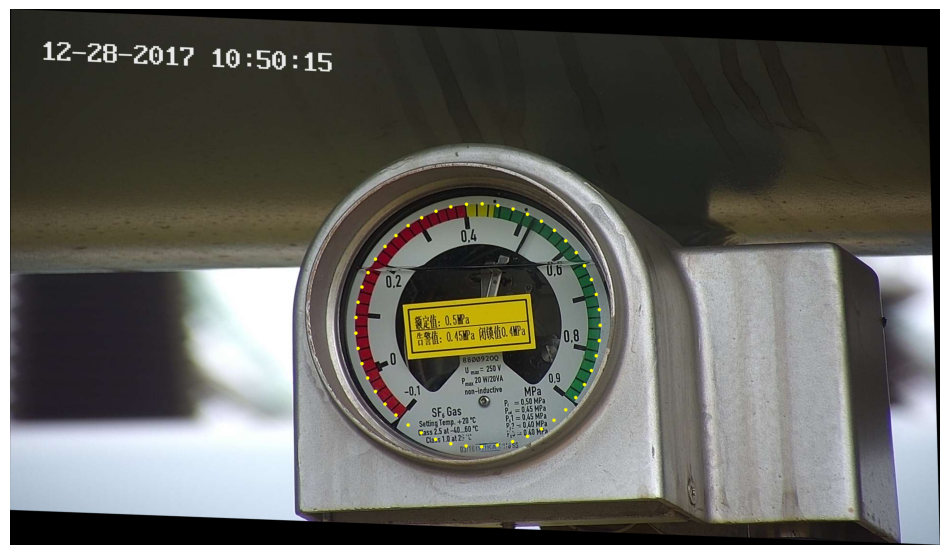

In [97]:
# 求解椭圆
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_img_correct, work_img.shape[1] - y_img_correct)

theta_res = np.linspace(0, 2*np.pi, 50)
x_res, y_res = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# 预览 检查椭圆曲线拟合
show_point(work_img, x_res, y_res, reversed=True)

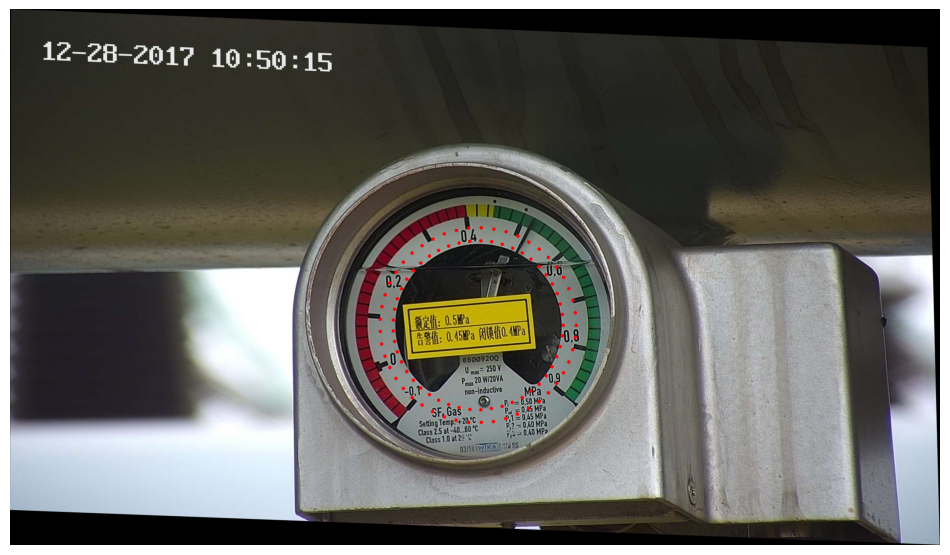

In [102]:
zone_point_x, zone_point_y = zone_point_correct[0], work_img.shape[1] - zone_point_correct[1]
zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([x_res[0], y_res[0]]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

# 扫描区域可视化
s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(work_img, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))